# Multi-label text classification using BERT

# Installing libraries

In [1]:
!nvidia-smi

Mon Aug 26 22:44:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0             30W /   95W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# RUN ONCE 
# %pip install transformers
# %pip install pandas
# %pip install numpy
# %pip install tqdm
# %pip install torch
# %pip install sklearn

# Importing Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
#import tqdm.notebook as tq
import tqdm as tq
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Reading and Cleaning Data

In [4]:
data_dir = "D:\MSc\Term 3 - Dissertation\Proj_in_VS\Data"
df_data = pd.read_excel("D:\\MSc\\Term 3 - Dissertation\\Proj_in_VS\\Data\\NSS2021_ StudentComments_ALL.xlsx",header=[3],sheet_name="NSS2021Comments")

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\malik\AppData\Local\Temp\ipykernel_29952\1062350272.py:1: SyntaxWarning: invalid escape sequence '\M'
  data_dir = "D:\MSc\Term 3 - Dissertation\Proj_in_VS\Data"


In [5]:
df_data.head()

,"=LEFT(AI5,125)&$A$3&LEFT(AJ5,125)",Programme [Course title]_Domicile (3-way)_Mode of Study_Age_Gender_Ethnicity_Disability_DSA recipient_POLAR quintile_IMD quintile_Socio-economic status_Entry qualification type_Level 2 GPA_Commuter Distance,C,_,College,Department,Division,Discipline,Programme [Course title],NSS Dept 1 code,...,TOT - International student experience,TOT - Student interaction,TOT - Differential treatment of students,TOT - Perceived discrimination,TOT - Personal experience,TOT - Student voice,TOT - Student Union and related activity,TOT - Social life and entertainment,"TOT - Sports (clubs, facilities etc)",TOT - Student societies
0,NaN,NaN,In,NaN,CBASS,Brunel Business School,"Globalisation, Entrepreneurship and Strategy",Management,Business and Management,UIAGMG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,In,NaN,CBASS,Brunel Business School,"Globalisation, Entrepreneurship and Strategy",Management,Business and Management,UIAGMG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,In,NaN,CBASS,Brunel Business School,"Globalisation, Entrepreneurship and Strategy",Management,Business and Management,UIAGMG,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,NaN,NaN,In,NaN,CBASS,Brunel Business School,"Globalisation, Entrepreneurship and Strategy",Management,Business and Management,UIAGMG,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,NaN,NaN,In,NaN,CBASS,Brunel Business School,"Globalisation, Entrepreneurship and Strategy",Management,Business and Management,UIAGMG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_data = df_data[['Positive comment','Negative comment','FLAG: Overall','FLAG: Covid-19 pandemic','FLAG: Teaching','FLAG: Learning opportunities','FLAG: Assessment and feedback','FLAG: Academic staff and support','FLAG: Organisation and management','FLAG: Learning resources','FLAG: Learning community','FLAG: Student voice','FLAG: Student Union and related']]

In [7]:
df_data[['FLAG: Overall',
      'FLAG: Covid-19 pandemic',
      'FLAG: Teaching',
      'FLAG: Learning opportunities',
      'FLAG: Assessment and feedback',
      'FLAG: Academic staff and support',
      'FLAG: Organisation and management',
      'FLAG: Learning resources',
      'FLAG: Learning community',
      'FLAG: Student voice',
      'FLAG: Student Union and related']] = df_data [['FLAG: Overall',
                                                   'FLAG: Covid-19 pandemic',
                                                   'FLAG: Teaching',
                                                   'FLAG: Learning opportunities',
                                                   'FLAG: Assessment and feedback',
                                                   'FLAG: Academic staff and support',
                                                   'FLAG: Organisation and management',
                                                   'FLAG: Learning resources',
                                                   'FLAG: Learning community',
                                                   'FLAG: Student voice',
                                                   'FLAG: Student Union and related']].fillna(0)

In [8]:
df_data.dropna(inplace=True)

In [9]:
df_data.rename(columns={'FLAG: Overall': 'Overall',
      'FLAG: Covid-19 pandemic' : 'Covid-19 pandemic',
      'FLAG: Teaching':'Teaching',
      'FLAG: Learning opportunities':'Learning opportunities',
      'FLAG: Assessment and feedback':'Assessment and feedback',
      'FLAG: Academic staff and support':'Academic staff and support',
      'FLAG: Organisation and management':'Organisation and management',
      'FLAG: Learning resources':'Learning resources',
      'FLAG: Learning community':'Learning community',
      'FLAG: Student voice':'Student voice',
      'FLAG: Student Union and related':'Student Union and related'}, inplace=True)

In [10]:
# Combine title and abstract to increase power


df_data["combined"] = df_data["Positive comment"] + ". " + df_data["Negative comment"]
df_data.drop(columns=["Positive comment", "Negative comment"], axis=1, inplace=True)

In [11]:
target_list = list(df_data.columns)
target_list
target_list = target_list[:-1]

## Data Augmentation

In [12]:
# For upsampling 
max_samples = int(df_data[target_list].sum(axis=1).max())
# For Downsampling
min_samples = int(df_data[target_list].sum(axis=1).min())

balanced_data = []

# Resample each label combination to the same number of samples
for _, group in df_data.groupby(target_list):
    balanced_data.append(resample(group, replace=True, n_samples=max_samples, random_state=42))

# Combine all balanced groups into one dataframe
df_balanced = pd.concat(balanced_data)

# Shuffle the dataframe to mix the rows well
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Now df_balanced is your balanced dataset
print(df_balanced['Overall'].value_counts())
print(df_balanced['Covid-19 pandemic'].value_counts())
# ... and so on for other columns

# Check the balanced dataframe
print(df_balanced.head())

Overall
0.0    2350
1.0    1230
Name: count, dtype: int64
Covid-19 pandemic
1.0    1790
0.0    1790
Name: count, dtype: int64
   Overall  Covid-19 pandemic  Teaching  Learning opportunities  \
0      0.0                1.0       0.0                     0.0   
1      0.0                0.0       0.0                     1.0   
2      0.0                0.0       1.0                     0.0   
3      1.0                1.0       0.0                     0.0   
4      0.0                1.0       0.0                     0.0   

   Assessment and feedback  Academic staff and support  \
0                      0.0                         1.0   
1                      0.0                         1.0   
2                      0.0                         1.0   
3                      1.0                         0.0   
4                      1.0                         1.0   

   Organisation and management  Learning resources  Learning community  \
0                          0.0                 1

In [13]:
df_balanced[target_list].sum()/len(df_balanced)

Overall                        0.343575
Covid-19 pandemic              0.500000
Teaching                       0.441341
Learning opportunities         0.547486
Assessment and feedback        0.432961
Academic staff and support     0.581006
Organisation and management    0.374302
Learning resources             0.491620
Learning community             0.298883
Student voice                  0.226257
Student Union and related      0.128492
dtype: float64

In [14]:
print(df_data[target_list].value_counts())

Overall  Covid-19 pandemic  Teaching  Learning opportunities  Assessment and feedback  Academic staff and support  Organisation and management  Learning resources  Learning community  Student voice  Student Union and related
0.0      0.0                0.0       0.0                     1.0                      1.0                         0.0                          0.0                 0.0                 0.0            0.0                          15
         1.0                0.0       0.0                     0.0                      0.0                         0.0                          0.0                 0.0                 0.0            0.0                          14
1.0      0.0                0.0       0.0                     0.0                      0.0                         0.0                          0.0                 0.0                 0.0            0.0                          13
0.0      0.0                1.0       0.0                     0.0                 

## Train Test Validation Splitting

In [15]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_balanced, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [16]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (2506, 12), Test: (537, 12), Valid: (537, 12)


## Model Building

### Hyperparameters

In [17]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1E-05

In [18]:
torch.__file__

'c:\\Users\\malik\\anaconda3\\Lib\\site-packages\\torch\\__init__.py'

### BERT Tokenizer

In [19]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html)
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['combined'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [22]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [23]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101,  4252,  3095,  2031,  2042,  6429,  2802,  1996,  2607,  2437,
          2469,  2057,  2024,  5117,  1010,  2024,  2045,  2000,  3749,  2490,
          1998,  6040,  2055,  2505,  2130,  2065,  2025,  3391,  2607,  3141,
          1998,  2031,  2428,  3271,  2033,  5959,  2026,  3395,  1012,  3391,
          2076,  1996,  6090,  3207,  7712,  2073,  2027,  2081,  3209,  2006,
          2192,  2130,  2062,  1012,  1996,  3218, 14184,  2031,  3024,  6322,
          2000,  2404,  2054,  2057,  2031, 20215,  2000,  2204,  3218,  1998,
          2031,  3253,  2444,  2537,  2420,  2000, 23216,  1037,  2739,  9954,
          4044,  1010,  4526,  1037,  2147,  2166,  6322,  1012,  6695,  2000,
          2147,  2006,  2824,  2107,  2004,  1996,  2236,  2602,  2001,  2028,
          1997,  1996, 11637,  1997,  2026,  2607,   999,  2009,  2001,  2307,
          2000,  2147,  2007,  2060,  5352,  1998,  2131,  1037,  2613,  2514,
          1997,  2129,  2122,  2824,  2

In [24]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

### Added Layers 

In [25]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(768, 11)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

### Loss Function

In [26]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class.
# This version is more numerically stable than using a plain Sigmoid followed
# by a BCELoss as, by combining the operations into one layer,
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

### Optimizer

In [27]:
from transformers import AdamW
from torch.optim import adam
from transformers import Adafactor
import torch.optim.adagrad

# define the optimizer
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)

#optimizer = Adafactor(model.parameters())

#optimizer = torch.optim.Adagrad(model.parameters(), lr=LEARNING_RATE)

c:\Users\malik\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Model Train and Evaluation Class

In [28]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='green')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [29]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

### Early Stopping

In [30]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Model Training

In [31]:
history = defaultdict(list)
best_accuracy = 0
early_stopper = EarlyStopper(patience=3, min_delta=0)


for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","MLTC_model_state.bin"))
        best_accuracy = val_acc

    if val_acc > best_accuracy and val_acc <= train_acc:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","MLTC_model_state2.bin"))

    if early_stopper.early_stop(val_loss):             
        break

Epoch 1/10


  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\malik\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 79/79 [06:43<00:00,  5.10s/it]


train_loss=0.6404, val_loss=0.5908 train_acc=0.6246, val_acc=0.6951
Epoch 2/10


100%|██████████| 79/79 [07:12<00:00,  5.47s/it]


train_loss=0.5833, val_loss=0.5415 train_acc=0.6916, val_acc=0.7434
Epoch 3/10


100%|██████████| 79/79 [07:25<00:00,  5.64s/it]


train_loss=0.5331, val_loss=0.4810 train_acc=0.7493, val_acc=0.8055
Epoch 4/10


100%|██████████| 79/79 [09:46<00:00,  7.43s/it]


train_loss=0.4734, val_loss=0.4200 train_acc=0.8026, val_acc=0.8546
Epoch 5/10


100%|██████████| 79/79 [09:30<00:00,  7.22s/it]


train_loss=0.4134, val_loss=0.3629 train_acc=0.8490, val_acc=0.8908
Epoch 6/10


100%|██████████| 79/79 [09:31<00:00,  7.24s/it]


train_loss=0.3587, val_loss=0.3122 train_acc=0.8897, val_acc=0.9253
Epoch 7/10


100%|██████████| 79/79 [09:42<00:00,  7.37s/it]


train_loss=0.3100, val_loss=0.2690 train_acc=0.9228, val_acc=0.9440
Epoch 8/10


100%|██████████| 79/79 [09:37<00:00,  7.32s/it]


train_loss=0.2640, val_loss=0.2271 train_acc=0.9512, val_acc=0.9653
Epoch 9/10


100%|██████████| 79/79 [09:29<00:00,  7.21s/it]


train_loss=0.2269, val_loss=0.1940 train_acc=0.9707, val_acc=0.9800
Epoch 10/10


100%|██████████| 79/79 [09:29<00:00,  7.21s/it]


train_loss=0.1939, val_loss=0.1660 train_acc=0.9816, val_acc=0.9851


# Model Evaluation

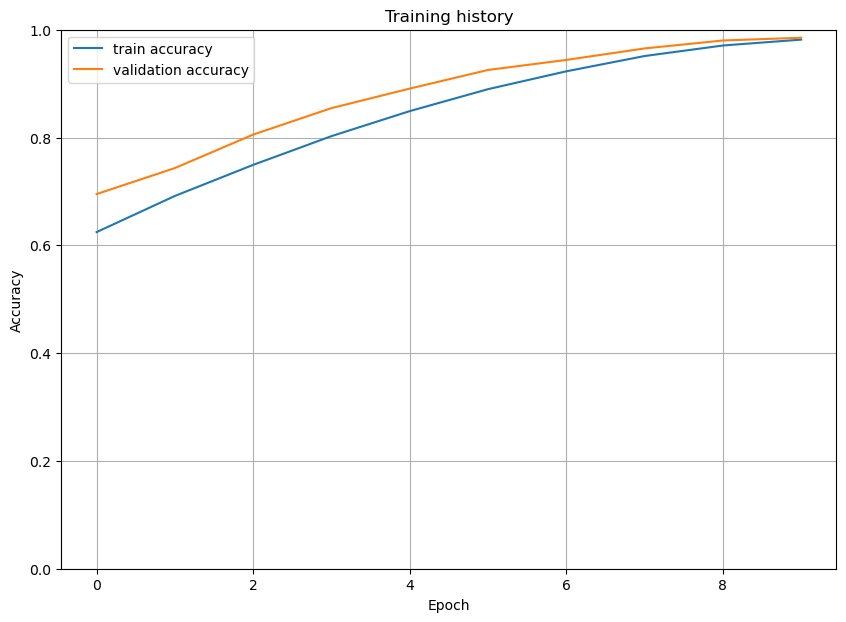

In [32]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

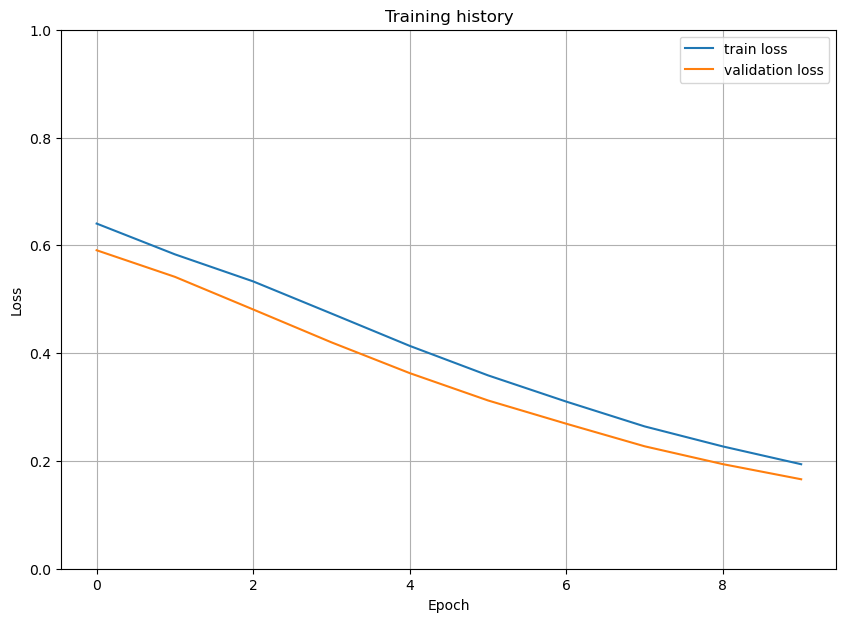

In [33]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Evaluation of the model

In [34]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))
model = model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [35]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [36]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.9864567462332825

In [37]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions -
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


In [38]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [39]:
# sanity check
predictions.numpy()

array([[1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [40]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:537 
predictions:torch.Size([537, 11]) 
prediction_probs:torch.Size([537, 11]) 
target_values:torch.Size([537, 11])


In [41]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list))

                             precision    recall  f1-score   support

                    Overall       1.00      1.00      1.00       184
          Covid-19 pandemic       1.00      0.98      0.99       261
                   Teaching       0.97      1.00      0.98       231
     Learning opportunities       0.98      0.98      0.98       319
    Assessment and feedback       1.00      1.00      1.00       243
 Academic staff and support       0.99      0.99      0.99       313
Organisation and management       0.99      0.93      0.95       216
         Learning resources       1.00      0.98      0.99       250
         Learning community       0.99      0.94      0.97       133
              Student voice       1.00      1.00      1.00       123
  Student Union and related       0.98      0.72      0.83        57

                  micro avg       0.99      0.98      0.98      2330
                  macro avg       0.99      0.96      0.97      2330
               weighted avg     

## Predicting on raw text

In [42]:
# raw text
raw_text = "I can tell that i got good teachers to learn from even though we were struck with covid-19."

In [43]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\malik\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2888: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [45]:
# Correctly identified the topic of the paper: High energy physics
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")

Title: I can tell that i got good teachers to learn from even though we were struck with covid-19.
Label: Covid-19 pandemic
Label: Teaching


In [46]:
def topic_print(output):
  new_output=[]
  for i in output:
    if(i>0.5):
      new_output.append(1)
    else:
      new_output.append(0)
  return new_output



# Testing

# example = test_data['Combined comment'][0]
all_outputs=[]
for example in df_test['combined']:
  encodings = tokenizer.encode_plus(
      example,
      None,
      add_special_tokens=True,
      max_length=MAX_LEN,
      padding='max_length',
      return_token_type_ids=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt'
  )
  model.eval()
  with torch.no_grad():
      input_ids = encodings['input_ids'].to(device, dtype=torch.long)
      attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
      token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
      output = model(input_ids, attention_mask, token_type_ids)
      final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
      # change argmax to a lambda function here
      #print(train_data.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])
      all_outputs.append(topic_print(final_output[0]))
      print(topic_print(final_output[0]))
      #print(final_output)



[1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0]
[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0]
[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0]
[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
[1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]
[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]
[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]
[0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
[1, 0, 1, 0, 0

In [47]:
example

"Some modules are better than others. Opportunities to develop through societies, etc. Some lecturers make the learning interesting and provide sufficient guidance. I enjoyed learning the topics, as they were relatable. The course was stimulating. The staff are nice and approachable.. Lack of module variety. Lack of department-student communication especially during COVID. Main issue is lack of communication. Did not sufficiently support students during COVID in comparison to other universities. Careers support isn't the best due to lack of strong connections with employers. More support could have been provided in the beginning to prepare effectively for exams. Needs to focus on exam technique, which isn't often taught enough. Compulsory dissertation but near to no guidance and support. Students' Union not the best in defending students and don't particularly like criticisms."

In [48]:
all_outputs[0]

[1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]

In [49]:
score=0
for i in range(len(all_outputs)):
  score += (all_outputs[i]==df_test.iloc[i][target_list]).sum()/len(target_list)


  #print(i,":",test_data.iloc[0][target_list])
  #t_score = (test_data.iloc[0][target_list]-i)
  #score += abs(t_score).sum()
  #print((test_data.iloc[0][target_list]-i).sum())

score = score/len(all_outputs)
print(score)

0.9864567462332832


In [50]:
preds = predictions.numpy()
# Calclulating counts for all labels
def calc_lbl_counts(preds):
  Lbl_Overall = 0
  Lbl_1 = 0
  Lbl_2 = 0
  Lbl_3 = 0
  Lbl_4 = 0
  Lbl_5 = 0
  Lbl_6 = 0
  Lbl_7 = 0
  Lbl_8 = 0
  Lbl_9 = 0
  Lbl_10 = 0
  for i in preds:
    Lbl_Overall += i[0]
    Lbl_1 += i[1]
    Lbl_2 += i[2]
    Lbl_3 += i[3]
    Lbl_4 += i[4]
    Lbl_5 += i[5]
    Lbl_6 += i[6]
    Lbl_7 += i[7]
    Lbl_8 += i[8]
    Lbl_9 += i[9]
    Lbl_10 += i[10]

  Labels = [Lbl_Overall,Lbl_1,Lbl_2,Lbl_3,Lbl_4,Lbl_5,Lbl_6,Lbl_7,Lbl_8,Lbl_9,Lbl_10]
  return Labels

Labels = calc_lbl_counts(preds)
print(Labels[0])

184.0


In [51]:
print(Labels[10])

42.0


In [52]:
sum=0
for i in Labels:
  sum+=i

print(sum)

type(sum)

Label_percs = Labels/np.float64(len(preds))
print(Label_percs[0])

2294.0
0.3426443202979516


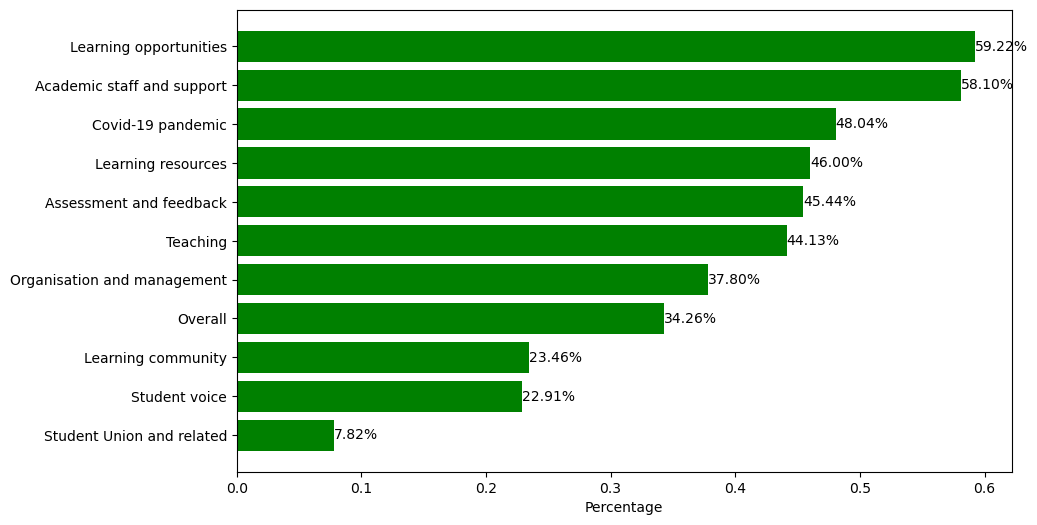

In [53]:
percentages = [i for i in Label_percs]

sorted_data = sorted(zip(percentages, target_list))
sorted_percentages, sorted_categories = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.barh(sorted_categories, sorted_percentages, color='green',edgecolor='none')
# plt.spines.set_visible(False)

plt.xlabel('Percentage')
plt.title('')

for index, value in enumerate(sorted_percentages):
    plt.text(value, index, f'{value*100:.2f}%', va='center')

plt.show()

# Exporting the Results

## Predicting labels for Year 22 and 23

In [54]:
# data2023 = pd.read_excel("D:\\MSc\\Term 3 - Dissertation\\Proj_in_VS\\Data\\NSS2023_BrunelStudentComments_published2023-10-11.xlsx",header=[2])
# data2022 = pd.read_excel("D:\\MSc\\Term 3 - Dissertation\\Proj_in_VS\\Data\\NSS2022_StudentComments_ALL_pub2022_0922.xlsx",header=[3])
# data2021 = pd.read_excel("D:\\MSc\\Term 3 - Dissertation\\Proj_in_VS\\Data\\NSS2021_ StudentComments_ALL.xlsx",header=[3],sheet_name="NSS2021Comments")

In [55]:
# data2021_pos = data2021['Positive comment']
# data2021_neg = data2021['Negative comment']
# data2022_pos = data2022['Positive comment']
# data2022_neg = data2022['Negative comment']
# data2023_pos = data2023['Positive comments']
# data2023_neg = data2023['Negative comments']

# #all_data_list = [data2021_pos,data2021_neg,data2022_pos,data2022_neg,data2023_pos,data2023_neg]
# pos_data_list = [data2021_pos,data2022_pos,data2023_pos]
# neg_data_list = [data2021_neg,data2022_neg,data2023_neg]

In [56]:
# data2021_pos.dropna(inplace=True)
# data2021_neg.dropna(inplace=True)
# data2022_pos.dropna(inplace=True)
# data2022_neg.dropna(inplace=True)
# data2023_pos.dropna(inplace=True)
# data2023_neg.dropna(inplace=True)

In [57]:
def get_preds(Comments):
    all_outputs=[]
    for example in Comments:
        encodings = tokenizer.encode_plus(
            example,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        model.eval()
        with torch.no_grad():
            input_ids = encodings['input_ids'].to(device, dtype=torch.long)
            attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
            output = model(input_ids, attention_mask, token_type_ids)
            final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
            # change argmax to a lambda function here
            #print(train_data.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])
            all_outputs.append(topic_print(final_output[0]))
            #print(topic_print(final_output[0]))
            #print(final_output)
    return all_outputs    

## Exporting the predictions to Excel files

In [58]:
# data2021_pos_results = get_preds(data2021_pos)
# data2021_neg_results = get_preds(data2021_neg)
# data2022_pos_results = get_preds(data2022_pos)
# data2022_neg_results = get_preds(data2022_neg)
# data2023_pos_results = get_preds(data2023_pos)
# data2023_neg_results = get_preds(data2023_neg)

In [59]:
def export_to_excel(indices,outputs,file_name):
    export_df = pd.DataFrame(outputs,columns=target_list,index=indices)
    export_df.to_excel(f'D:\\MSc\\Term 3 - Dissertation\\Proj_in_VS\\exported_files\\{file_name}.xlsx')

In [60]:
# export_to_excel(data2021_pos,data2021_pos_results,'PositiveComments2021')
# export_to_excel(data2022_pos,data2022_pos_results,'PositiveComments2022')
# export_to_excel(data2023_pos,data2023_pos_results,'PositiveComments2023')
# export_to_excel(data2021_neg,data2021_neg_results,'NegativeComments2021')
# export_to_excel(data2022_neg,data2022_neg_results,'NegativeComments2022')
# export_to_excel(data2023_neg,data2023_neg_results,'NegativeComments2023')


In [61]:
# #OG Code

# export_df = pd.DataFrame(all_outputs,columns=target_list,index=df_test['combined'])
# #export_df['comment'] = df_data['combined']

# export_df.to_excel('results.xlsx')

# export_df